<a href="https://colab.research.google.com/github/LM1997610/Social_Networks/blob/main/Project/Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <h1><center>Social Networks and Online Markets</center></h1>
## <h2><center>Wikipedia Graph</center></h2>
## <h4><center>2023/2024</center></h4>
## <h3><center>Luca Mazzucco: 1997610</center></h3>

In [1]:
! pip -q install scikit-network

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 50.6 MB/s eta 0:00:00


In [2]:
import os
import sys
import warnings

import pickle
import random
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.cm

from tqdm.auto import tqdm
from tabulate import tabulate
from collections import Counter
from IPython.display import Image

from sknetwork.data import load_netset

In [3]:
! git clone -q https://github.com/LM1997610/Social_Networks

if os.getcwd().split('/')[-1] != 'Social_Networks':
   os.chdir('Social_Networks/Project')

from visualize import topic_distrib_plot
from visualize import visualize_degree_distrib
from visualize import show_length_of_paths
from visualize import deg_separation_plot
from visualize import dead_end_plot
from visualize import in_out_plot

from visualize_graph import show_subnet
from visualize_graph import show_communities

output_dir = 'plot_folder'

if not os.path.exists(output_dir): os.makedirs(output_dir)

warnings.filterwarnings("ignore", category=matplotlib.MatplotlibDeprecationWarning)

### **[WikiVitals](https://netset.telecom-paris.fr/pages/wikivitals.html)** dataset:
Vital articles of [Wikipedia](https://en.wikipedia.org/wiki/Wikipedia:Vital_articles/Level/4) in English

In [4]:
wikivitals = load_netset('wikivitals')

Unpacking archive...
Parsing files...
Done.


In [5]:
label_id = {name: i for i, name in enumerate(wikivitals.names_labels)}

counted_topics = {category: Counter(wikivitals.labels)[id] for category, id in label_id.items()}

table_data = [(category, count) for category, count in counted_topics.items()]

print(tabulate(table_data, headers=["Label", "Counter"]))

Label                             Counter
------------------------------  ---------
Arts                                  673
Biological and health sciences       1479
Everyday life                         479
Geography                            1201
History                               680
Mathematics                           300
People                               1991
Philosophy and religion               435
Physical sciences                    1097
Society and social sciences           930
Technology                            746


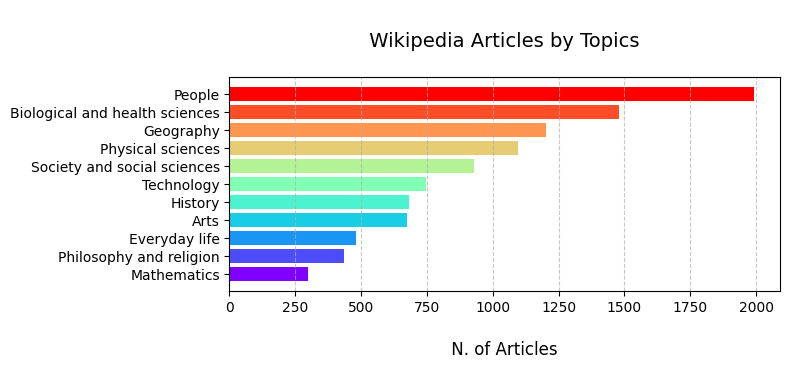

In [6]:
topic_distrib_plot(counted_topics, output_directory = output_dir)

In [7]:
adj_matrix = wikivitals.adjacency.toarray().astype(int)

G = nx.DiGraph(wikivitals.adjacency.toarray())
#G = nx.from_numpy_array(wikivitals.adjacency.toarray())

print()
print(f'Graph is undirected: {np.array_equal(adj_matrix, adj_matrix.T)}')
print(f'Graph is directed: {G.is_directed()}\n')

print(f'Number of nodes: {len(G.nodes)}')
print(f'Number of edges: {len(G.edges)}\n')

self_loops = list(nx.selfloop_edges(G))
G.remove_edges_from(self_loops)

print(f'>> removed {len(self_loops)} self-edge from the graph: {len(G.edges)} edges \n')

isolated_nodes = [node for node in G.nodes if G.degree(node) == 0]
print(f'Number of isolated nodes: {len(isolated_nodes)}')


Graph is undirected: False
Graph is directed: True

Number of nodes: 10011
Number of edges: 824999

>> removed 1380 self-edge from the graph: 823619 edges 

Number of isolated nodes: 0


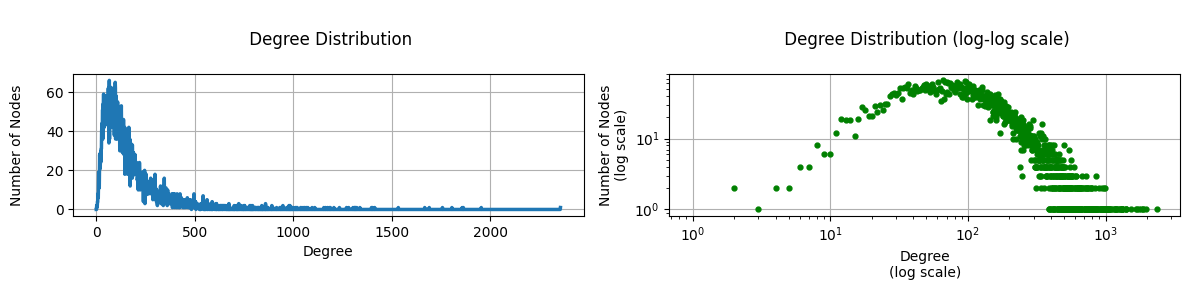

In [8]:
degree_distrib = nx.degree_histogram(G)
nodes = [i for i in range(0, len(degree_distrib))]

degree_distrib = [degree_distrib[i] for i in range(len(degree_distrib))]

visualize_degree_distrib(nodes, degree_distrib, output_directory = output_dir)

In [9]:
## For each topic, what are the most cited articles? → Edge analysis

def top_cited_articles(class_id, n):

  this_class = [x for x,y in enumerate(wikivitals.labels) if y == class_id]
  subgraph = G.subgraph(this_class)

  node_edge_counts = {node: subgraph.degree(node) for node in subgraph.nodes()}

  top_nodes = {k: v for k, v in sorted(node_edge_counts.items(), key=lambda item: item[1], reverse=True)}

  top_nodes_names = {(wikivitals.names[idx], idx): count for idx, count in top_nodes.items()}


  return [(k, top_nodes_names[k]) for k in list(top_nodes_names)][:n]

In [10]:
article_list = []

for i in range(11):

  this_label = [key for key in label_id.keys() if label_id[key] == i][0]
  this_top =  [x for x in top_cited_articles(i, 5)]
  node_indexes = [s[0][1] for s in this_top]
  article_list.append(node_indexes)

  to_print  = ["'" + s[0][0] + "'" for s in this_top]
  print(f'[{this_label:>30}] → {", ".join(to_print)}')

articles = [item for sublist in article_list for item in sublist]

[                          Arts] → 'Romanticism', 'Modernism', 'Symbolism (arts)', 'Modern art', 'Baroque'
[Biological and health sciences] → 'Taxonomy (biology)', 'Animal', 'Chordate', 'Plant', 'Mammal'
[                 Everyday life] → 'Marriage', 'Olympic Games', 'Softball', 'Rugby sevens', 'Association football'
[                     Geography] → 'Geographic coordinate system', 'France', 'Europe', 'United States', 'China'
[                       History] → 'Ottoman Empire', 'Roman Empire', 'Byzantine Empire', 'Russian Empire', 'British Empire'
[                   Mathematics] → 'Mathematical analysis', 'Real number', 'Geometry', 'Function (mathematics)', 'Mathematics'
[                        People] → 'Ralph Waldo Emerson', 'Aristotle', 'Bertrand Russell', 'Jean-Jacques Rousseau', 'Georg Wilhelm Friedrich Hegel'
[       Philosophy and religion] → 'Religion', 'Christianity', 'Taoism', 'Mysticism', 'Pantheism'
[             Physical sciences] → 'Oxygen', 'Hydrogen', 'Earth', 'Chemi

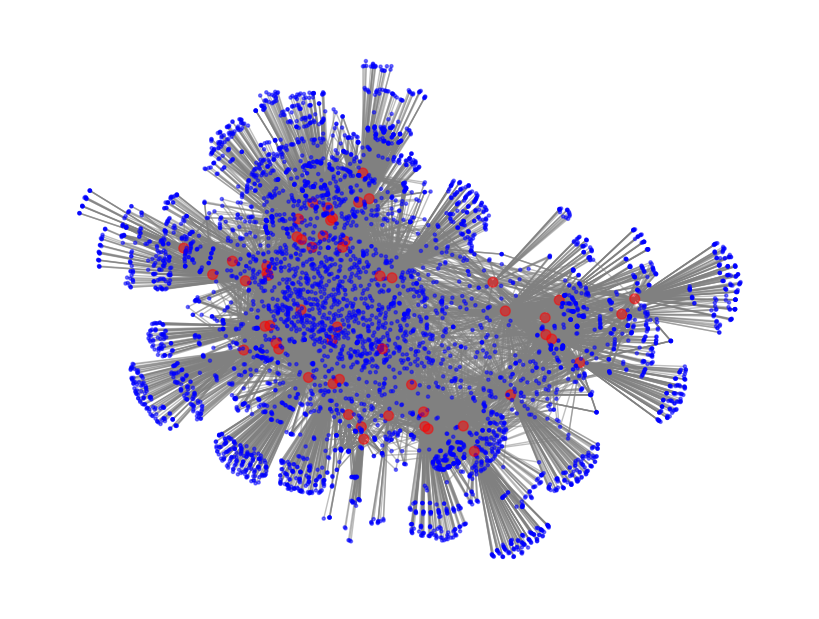

In [11]:
H = nx.Graph()

for article in articles:

    H.add_node(article, color='red', size=50)

    neighbors = list(G.neighbors(article))
    for neighbor in neighbors:
        if neighbor not in articles:
            H.add_node(neighbor, color='blue', size=5)
        H.add_edge(article, neighbor)

pos = nx.spring_layout(H)

colors = [H.nodes[node]['color'] for node in H.nodes()]
sizes = [H.nodes[node]['size'] for node in H.nodes()]

plt.figure(figsize=(8, 6))
nx.draw(H, pos, with_labels=False, node_color=colors, edge_color='gray', alpha=0.5,
                                                      node_size=sizes, font_size=10, font_color='white')

plt.savefig("plot_folder/all_graph.png")
plt.show()

In [12]:
print(f'Number of nodes: {len(H.nodes)}')

Number of nodes: 5304


## Wikipedia Races

The **[Wikipedia game](https://www.thewikipediagame.com/)** involves navigating from one Wikipedia page to another using as few steps/links as possible. \
Starting from a Wikipedia page on a topic, click blue links to move to other pages until reached the target page.

The goal is to get the destination article as fast as possible using the fewest number of link clicks

In [13]:
## WIKIPEDIA RACE

In [14]:
def get_neighbors_at_levels(G, node, max_level=7):

    levels = {0: [node]}
    visited = {node}

    for level in range(1, max_level + 1):
        neighbors = set()

        for n in levels[level - 1]:
            neighbors.update(set(G.successors(n)) - visited)

        if not neighbors: break

        levels[level] = list(neighbors)
        visited.update(neighbors)

    return levels

In [15]:
node_index = 2951

result = get_neighbors_at_levels(G, node_index, max_level=7)

print(f'Node: {wikivitals.names[2951]} - idx: {node_index}\n')

for k,v in result.items():
  print(f'level: {k} → connections reached: [{len(v)}]')

Node: Europe - idx: 2951

level: 0 → connections reached: [1]
level: 1 → connections reached: [679]
level: 2 → connections reached: [6927]
level: 3 → connections reached: [2354]
level: 4 → connections reached: [20]


In [16]:
def cum_sum(una_lista):
  cumulative_sums = []
  cumulative_sum = 0
  for lst in una_lista.values():
      cumulative_sum += len(lst)
      cumulative_sums.append(cumulative_sum)

  return cumulative_sums

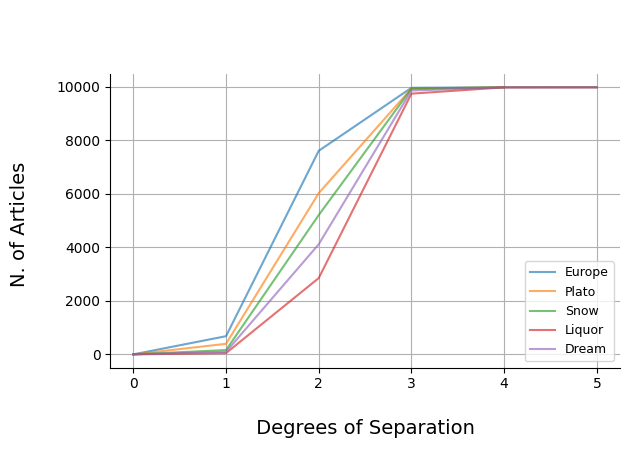

In [17]:
indexes= [2951, 7108, 8319, 5365, 2526]

data = {}

for i in range(len(indexes)):

  results = get_neighbors_at_levels(G, indexes[i], max_level=8)
  data[wikivitals.names[indexes[i]]] = cum_sum(results)

data, table, not_reached = deg_separation_plot(data, total_nodes = len(list(G.nodes())), output_directory=output_dir )


In [18]:
table_data = [ [key] + v for key, v in data.items()]
headers = ["Node"] + [f"Hop {i}" for i in range(7)]

print(tabulate(table_data, headers=headers, tablefmt="pretty"))

+--------+-------+-------+-------+-------+-------+-------+
|  Node  | Hop 0 | Hop 1 | Hop 2 | Hop 3 | Hop 4 | Hop 5 |
+--------+-------+-------+-------+-------+-------+-------+
| Europe |   1   |  680  | 7607  | 9961  | 9981  |       |
| Plato  |   1   |  395  | 6025  | 9936  | 9981  |       |
|  Snow  |   1   |  162  | 5206  | 9926  | 9980  | 9981  |
| Liquor |   1   |  48   | 2852  | 9743  | 9978  | 9981  |
| Dream  |   1   |  96   | 4115  | 9860  | 9980  | 9981  |
+--------+-------+-------+-------+-------+-------+-------+


In [19]:
print(table, '\n')
print(f'Unreachable portion of the graph: {not_reached} %')

+--------+-----------+-----------+------------+------------+------------+------------+
|  Node  |   Hop 0   |   Hop 1   |   Hop 2    |   Hop 3    |   Hop 4    |   Hop 5    |
+--------+-----------+-----------+------------+------------+------------+------------+
| Europe | 0.00999 % | 6.79253 % | 75.98641 % | 99.50055 % | 99.70033 % |            |
| Plato  | 0.00999 % | 3.94566 % | 60.1838 %  | 99.25082 % | 99.70033 % |            |
|  Snow  | 0.00999 % | 1.61822 % | 52.0028 %  | 99.15093 % | 99.69034 % | 99.70033 % |
| Liquor | 0.00999 % | 0.47947 % | 28.48866 % | 97.32294 % | 99.67036 % | 99.70033 % |
| Dream  | 0.00999 % | 0.95895 % | 41.10478 % | 98.49166 % | 99.69034 % | 99.70033 % |
+--------+-----------+-----------+------------+------------+------------+------------+ 

Unreachable portion of the graph: 0.2997 %


----------------------------------------------------------------------

In [20]:
def find_orphan_nodes(adjacency_matrix, graph):

    orphan_nodes = []

    for j in range(adjacency_matrix.shape[0]):

        if np.all(adjacency_matrix[:, j] == 0): orphan_nodes.append(j)

    for node in orphan_nodes:
      if list(graph.predecessors(node)): raise ValueError(f'Node {node} is not orphan!')

    return orphan_nodes

In [21]:
def find_dead_ends(adjacency_matrix, graph):

    death_ends = []

    for i in range(adjacency_matrix.shape[0]):

        if np.all(adjacency_matrix[i, :] == 0): death_ends.append(i)

    for node in death_ends:
      if list(graph.successors(node)): raise ValueError(f'Node {node} is not dead end!')

    return death_ends

In [22]:
total_nodes = len(list(G.nodes()))

orphan_nodes = find_orphan_nodes(adj_matrix, G)
death_ends = find_dead_ends(adj_matrix, G)

print()
print(f'total number of nodes: {total_nodes}')
print(f'number of Orphan nodes: {len(orphan_nodes)}')
print(f'number of DeadEnd nodes: {len(death_ends)}\n')

not_reachable = round( len(orphan_nodes)  / total_nodes * 100, 4)
#not_reachable = round((len(orphan_nodes) + len(death_ends)) / total_nodes * 100, 4)

print(f'Unreachable portion of the graph: {not_reachable} %')


total number of nodes: 10011
number of Orphan nodes: 30
number of DeadEnd nodes: 2

Unreachable portion of the graph: 0.2997 %


In [23]:
# An orphan node can NOT be path destination -> Un-reachable
# A DeadEnd node can NOT be path origin -> Un-startable

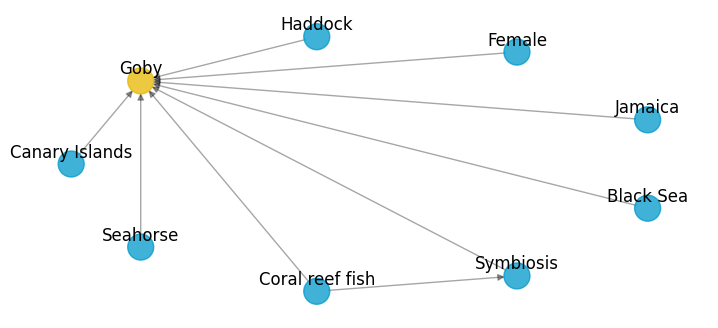

In [24]:
dead_end_plot(G, death_ends[1], wikivitals.names)

--------------------------------------------------------
---------------------------------------------------------

### Average path length

In [25]:
def dijkstra_shortest_path(graph, source, target):

    distances = {node: float('inf') for node in graph.nodes()}
    distances[source] = 0

    predecessors = {node: None for node in graph.nodes()}

    queue = [source]

    while queue:
        current_node = queue.pop(0)

        if current_node == target:
            path = []
            backtrack_node = current_node
            while backtrack_node is not None:
                path.insert(0, backtrack_node)
                backtrack_node = predecessors[backtrack_node]
            return path


        for neighbor in graph.neighbors(current_node):
            if distances[neighbor] == float('inf'):  # Se non è stato visitato
                distances[neighbor] = distances[current_node] + 1
                predecessors[neighbor] = current_node
                queue.append(neighbor)


    return []

In [26]:
start_node_idx = 980   # Beer
end_node_idx = 997     # Belly dance

shortest_path = dijkstra_shortest_path(G, start_node_idx, end_node_idx)
## shortest_path = nx.dijkstra_path(G, start_node_idx, end_node_idx)

print('\n Start:', end = " ")

for i, idx_number in enumerate(shortest_path):

  print(f'[{wikivitals.names[idx_number]}] → ', end = "")

print('destination \n')
print(f'length = {len(shortest_path)} >> {shortest_path}')

## Start: [Belly dance] → [Africa] → [Germany] → [Beer] → destination
## length = 4 >> [997, 151, 3517, 980]


 Start: [Beer] → [Ancient Egypt] → [Egypt] → [Belly dance] → destination 

length = 4 >> [980, 422, 2680, 997]


In [27]:
start_node_idx = 2988   # Exponential distribution
end_node_idx = 2071     # Corvus

shortest_path = dijkstra_shortest_path(G, start_node_idx, end_node_idx)

print('\n Start:', end = " ")
for i, idx_number in enumerate(shortest_path):

  print(f'[{wikivitals.names[idx_number]}] → ', end = "")

print(f'destination || len = {len(shortest_path)}')


 Start: [Exponential distribution] → [DNA] → [Animal] → [Bird] → [Common raven] → [Corvus] → destination || len = 6


In [28]:
## Reverse path:
shortest_path = dijkstra_shortest_path(G, end_node_idx, start_node_idx)

print('\n Start:', end = " ")
for i, idx_number in enumerate(shortest_path):

  print(f'[{wikivitals.names[idx_number]}] → ', end = "")

print(f'destination || len = {len(shortest_path)}')


 Start: [Corvus] → [Animal] → [Rain] → [Exponential distribution] → destination || len = 4


In [29]:
iterations = 20000

d = {}

if os.path.exists("length_of_paths.pickle"):
  with open("length_of_paths.pickle", 'rb') as f: d = pickle.load(f)

else:
  for i in tqdm(range(iterations)):

    node1, node2 = random.sample(list(G.nodes()), 2)

    # while node1 in death_ends or node2 in orphan_nodes:
      #  node1, node2 = random.sample(list(G.nodes()), 2)

    while (node1, node2) in d:
      node1, node2 = random.sample(list(G.nodes()), 2)

    shortest_path = dijkstra_shortest_path(G, node1, node2 )

    d[(node1, node2)] = shortest_path[1:]

  with open('length_of_paths.pickle', 'wb') as f: pickle.dump(d, f)

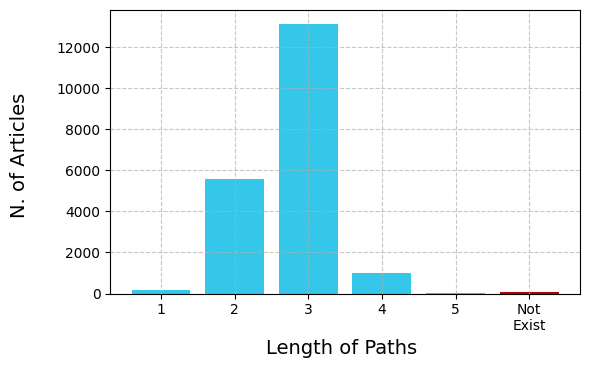



╒═══════════════════╤═════════════╤═════╤══════╤═══════╤══════╤═════╕
│ Lenght of path:   │  Not Exist  │  1  │  2   │   3   │  4   │  5  │
╞═══════════════════╪═════════════╪═════╪══════╪═══════╪══════╪═════╡
│ Nodes (couples):  │     58      │ 161 │ 5601 │ 13151 │ 1016 │ 13  │
╘═══════════════════╧═════════════╧═════╧══════╧═══════╧══════╧═════╛


In [30]:
counter = dict(Counter(len(v) for v in d.values()))
sorted_counter = dict(sorted(counter.items()))

show_length_of_paths(sorted_counter, output_directory=output_dir )

In [31]:
total_keys = sum(list(sorted_counter.values())[1:])

weighted_sum = sum(length * count for length, count in sorted_counter.items())

weighted_average = round(weighted_sum / total_keys, 2)

print(f"Average path length {weighted_average}")

Average path length 2.76


In [32]:
## A small world network is characterized by a small average shortest path length, and a large clustering coefficient.

--------------------------------------------------------------------------
---------------------------------------------------------------------------

## Sub-Networks:

In [33]:
from wiki_graph_module import SubgraphBuilder

In [34]:
label_id = {name: i for i, name in enumerate(wikivitals.names_labels)}

In [35]:
graph_handler = {}

for topic_key in tqdm(label_id):

  builder = SubgraphBuilder(G, topic_key, label_id, wikivitals.labels, wikivitals.labels_hierarchy,
                                                    wikivitals.names_labels_hierarchy)
  graph_handler[builder.topic_name] = builder

  show_subnet(builder, show=False)
  print('{:>13} >> Nodes: {:>4} | Edges: {:>5} | Subclasses: {:>2} | Isolated: {:>2} | Components: {}'.format(*builder.info))

  0%|          | 0/11 [00:00<?, ?it/s]

       [Arts] >> Nodes:  666 | Edges: 11810 | Subclasses:  9 | Isolated:  7 | Components: 1
 [Biological] >> Nodes: 1479 | Edges: 55056 | Subclasses: 10 | Isolated:  0 | Components: 1
   [Everyday] >> Nodes:  479 | Edges:  9977 | Subclasses:  7 | Isolated:  0 | Components: 1
  [Geography] >> Nodes: 1201 | Edges: 88227 | Subclasses:  6 | Isolated:  0 | Components: 1
    [History] >> Nodes:  680 | Edges: 28519 | Subclasses: 11 | Isolated:  0 | Components: 1
[Mathematics] >> Nodes:  300 | Edges:  9659 | Subclasses:  7 | Isolated:  0 | Components: 1
     [People] >> Nodes: 1969 | Edges: 67077 | Subclasses: 15 | Isolated: 17 | Components: 3
 [Philosophy] >> Nodes:  435 | Edges: 24342 | Subclasses:  6 | Isolated:  0 | Components: 1
   [Physical] >> Nodes: 1097 | Edges: 60692 | Subclasses:  6 | Isolated:  0 | Components: 1
    [Society] >> Nodes:  929 | Edges: 26403 | Subclasses: 15 | Isolated:  1 | Components: 1
 [Technology] >> Nodes:  746 | Edges: 14086 | Subclasses: 17 | Isolated:  0 | Co

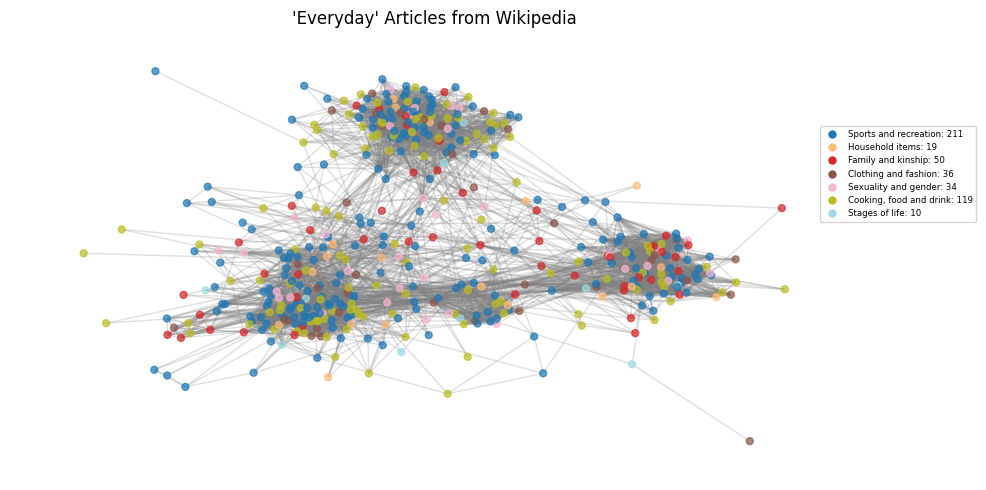

In [36]:
community_label = "Everyday"

show_subnet(graph_handler[community_label], show=True)

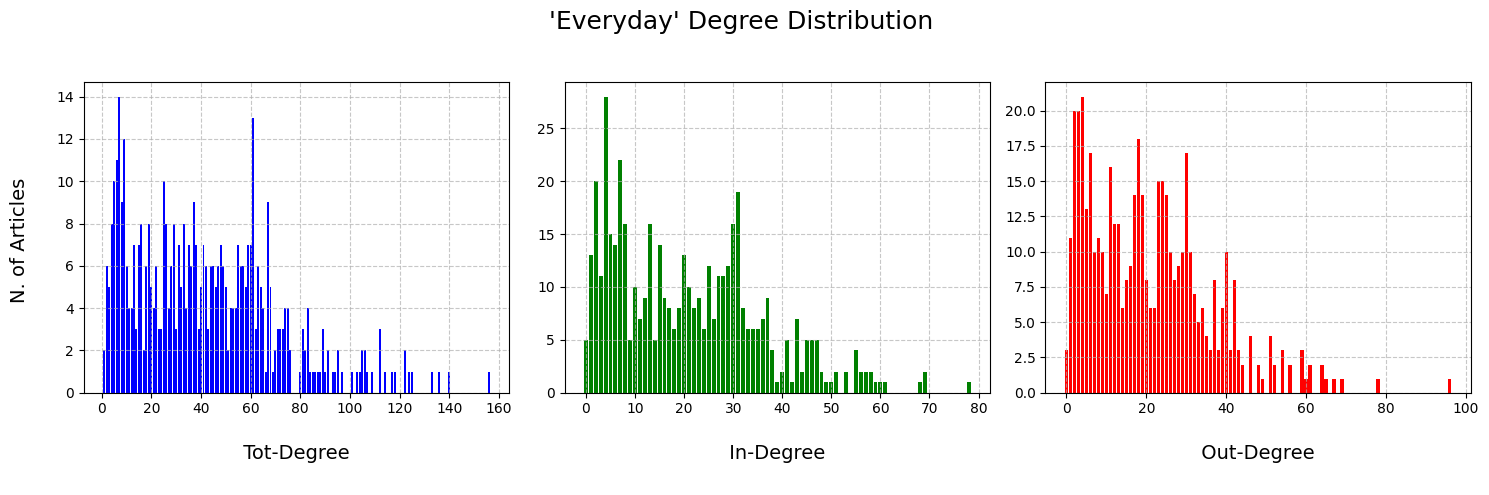

In [37]:
degrees, in_deg, out_deg = graph_handler[community_label].compute_distribution()

in_out_plot(degrees, in_deg, out_deg, community_label, output_directory=output_dir)

In [38]:
# Looking for Hubs: (percentile -> 95)

for key in graph_handler.keys():

  hubs = graph_handler[key].find_hubs()

  print(f'{graph_handler[key].info[0]:>13} >> Hubs: {len(hubs)} -> {graph_handler[key].avg_clustering}', end =" ")
  average_clusstering_dir = round(nx.average_clustering(graph_handler[key].subgraph), 3)
  print(f'{average_clusstering_dir}')

# Undirected average_clustering vs Directed average_clustering:

       [Arts] >> Hubs: 33 -> 0.381 0.331
 [Biological] >> Hubs: 74 -> 0.386 0.318
   [Everyday] >> Hubs: 24 -> 0.529 0.489
  [Geography] >> Hubs: 58 -> 0.525 0.431
    [History] >> Hubs: 34 -> 0.478 0.409
[Mathematics] >> Hubs: 15 -> 0.476 0.412
     [People] >> Hubs: 99 -> 0.424 0.416
 [Philosophy] >> Hubs: 22 -> 0.564 0.494
   [Physical] >> Hubs: 54 -> 0.428 0.397
    [Society] >> Hubs: 46 -> 0.35 0.298
 [Technology] >> Hubs: 38 -> 0.378 0.325


### Centrality Measures:

In [39]:
from PIL import Image

In [40]:
## Centrality Measures:
## [Degree Centrality] - [Betweenness Centrality] - [Closeness Centrality]

top_acrticles = {}

for key in graph_handler.keys():

  print(f'{graph_handler[key].info[0]:>13} >> ', end = '')
  top_acrticles[key] = graph_handler[key].get_all_centralities(wikivitals.names)

       [Arts] >> 

100%|██████████| 4/4 [00:06<00:00,  1.51s/it]


 [Biological] >> 

100%|██████████| 4/4 [00:39<00:00,  9.91s/it]


   [Everyday] >> 

100%|██████████| 4/4 [00:04<00:00,  1.00s/it]


  [Geography] >> 

100%|██████████| 4/4 [00:42<00:00, 10.54s/it]


    [History] >> 

100%|██████████| 4/4 [00:11<00:00,  2.81s/it]


[Mathematics] >> 

100%|██████████| 4/4 [00:03<00:00,  1.13it/s]


     [People] >> 

100%|██████████| 4/4 [00:54<00:00, 13.55s/it]


 [Philosophy] >> 

100%|██████████| 4/4 [00:07<00:00,  1.91s/it]


   [Physical] >> 

100%|██████████| 4/4 [00:32<00:00,  8.02s/it]


    [Society] >> 

100%|██████████| 4/4 [00:14<00:00,  3.53s/it]


 [Technology] >> 

100%|██████████| 4/4 [00:07<00:00,  1.85s/it]


In [41]:
for key in graph_handler.keys():

  this_key = key

  print(f' \n Topic: {this_key}')

  for metric, articles in list( top_acrticles[this_key].items())[:3]:
    print(f'{metric:>22} --> {articles}')

 
 Topic: Arts
  closeness_centrality --> {'Romanticism': 0.53, 'Modernism': 0.516, 'Symbolism (arts)': 0.502}
betweenness_centrality --> {'Romanticism': 0.056, 'Modernism': 0.042, 'Baroque': 0.035}
     degree_centrality --> {'Romanticism': 0.22, 'Modernism': 0.177, 'Baroque': 0.167}
 
 Topic: Biological
  closeness_centrality --> {'Taxonomy (biology)': 0.704, 'Animal': 0.64, 'Chordate': 0.585}
betweenness_centrality --> {'Taxonomy (biology)': 0.166, 'Animal': 0.068, 'Species': 0.032}
     degree_centrality --> {'Taxonomy (biology)': 0.595, 'Animal': 0.451, 'Chordate': 0.335}
 
 Topic: Everyday
  closeness_centrality --> {'Tourism': 0.469, 'Entertainment': 0.465, 'Food': 0.454}
betweenness_centrality --> {'Food': 0.096, 'Entertainment': 0.055, 'Game': 0.045}
     degree_centrality --> {'Olympic Games': 0.209, 'Food': 0.182, 'Marriage': 0.178}
 
 Topic: Geography
  closeness_centrality --> {'Geographic coordinate system': 0.93, 'United States': 0.649, 'France': 0.634}
betweenness_centr

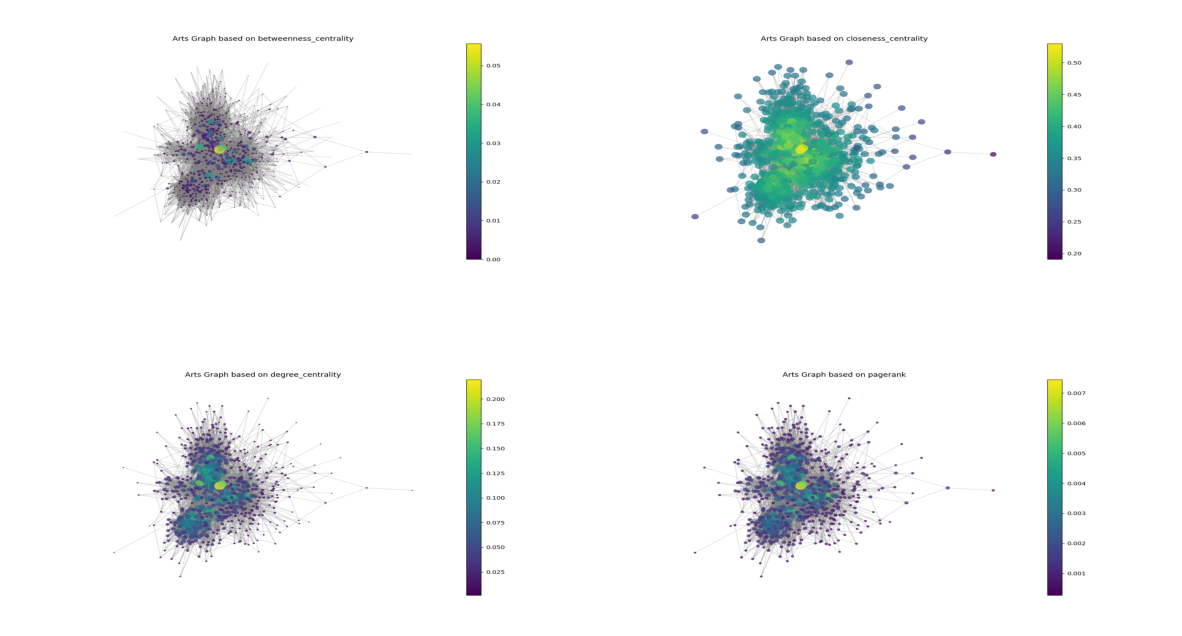

In [42]:
folder_path = '/content/Social_Networks/Project/plot_folder/centrality_measures/'

image_filenames = ['arts_betweenness.png', 'arts_closeness.png',
                   'arts_degree.png',      'arts_pagerank.png']

image_paths = [os.path.join(folder_path, filename) for filename in image_filenames]

fig, axs = plt.subplots(2, 2, figsize=(15, 8))

for ax, img_path in zip(axs.flat, image_paths):
    img = Image.open(img_path)
    ax.imshow(img, aspect="auto")
    ax.axis('off')

plt.subplots_adjust(wspace=0)
plt.show()

### Community Detection:

In [43]:
## LOUVAIN

for topic_name, machine in tqdm(graph_handler.items()):

  partition = nx.community.louvain_communities(machine.subgraph)
  show_communities(machine, partition, show=False)


  0%|          | 0/11 [00:00<?, ?it/s]

In [44]:
from IPython.display import display, Image

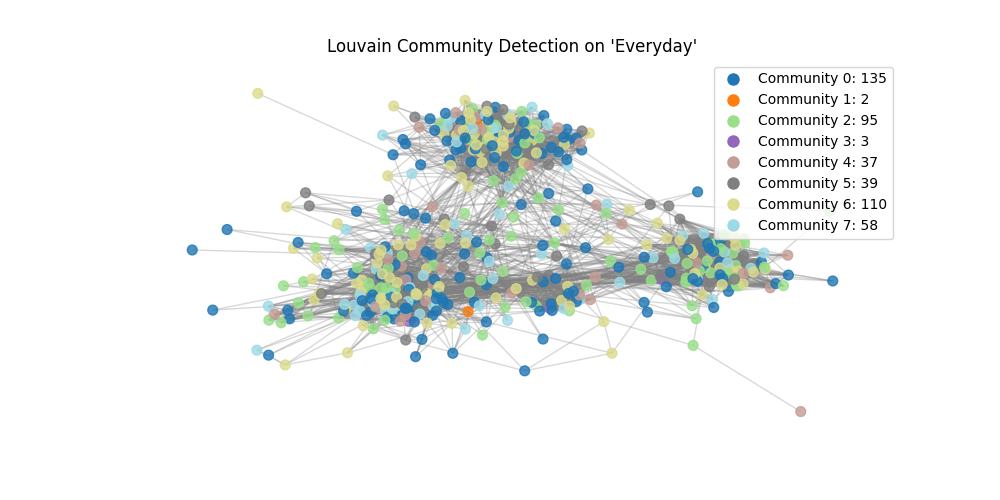

In [45]:
this_image = "/content/Social_Networks/Project/plot_folder/louvain/louvain_everyday.png"

display(Image(filename = this_image))

In [46]:
!zip -r -q /content/plot_folder.zip /content/Social_Networks/Project/plot_folder

## Text Model



In [47]:
! pip install --q -U datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 26.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 14.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [48]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [49]:
import torch
import seaborn as sns

from functools import partial
from datasets import Dataset

from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from transformers import (AutoModel, AutoTokenizer)
from sklearn.metrics import accuracy_score, confusion_matrix

In [50]:
model_name = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [94]:
articles_data = []

for i in tqdm(range(len(wikivitals.names))):

  word_indices = wikivitals.biadjacency[i].nonzero()[1]

  articles_data.append({
        'article_name': wikivitals.names[i],
        'words': " ".join([wikivitals['names_col'][i] for i in word_indices]),
        'label_name': wikivitals.names_labels[wikivitals.labels[i]],
        'label_index': wikivitals.labels[i]  })

df = pd.DataFrame(articles_data)

df.head()

  0%|          | 0/10011 [00:00<?, ?it/s]

article_name                                              words  \
0                        0  from historically identity system zero for be ...   
1                        1  can often from identity by neither matter most...   
2               100 metres  straight Christian there often block less Cham...   
3          14th Dalai Lama  family November establish Congressional religi...   
4  1556 Shaanxi earthquake  city Ming wide live be on county Hunan More mi...   

      label_name  label_index  
0    Mathematics            5  
1    Mathematics            5  
2  Everyday life            2  
3         People            6  
4        History            4

In [95]:
def tokenize_function(example, tokenizer):
    out_dict = tokenizer(example["words"], truncation=True, padding=True)
    out_dict["label"] = example["label_index"]
    return out_dict

In [96]:
train_val, test = train_test_split(df, test_size=0.09, random_state=42)

train, valid = train_test_split(train_val, test_size=0.15, random_state=42)

train = train.reset_index(drop=True)
valid = valid.reset_index(drop=True)
test =  test.reset_index(drop=True)

print(f"Train size: {len(train)/len(df):>.3}")
print(f"Valid size: {len(valid)/len(df):>.3}")
print(f"Test size:  {len(test)/len(df):>.3}")

Train size: 0.773
Valid size: 0.137
Test size:  0.09


In [97]:
train_ds = Dataset.from_pandas(train).map(
    partial(tokenize_function, tokenizer=tokenizer),
    batched=True,
    batch_size=len(train) )

val_ds = Dataset.from_pandas(valid).map(
    partial(tokenize_function, tokenizer=tokenizer),
    batched=True,
    batch_size=len(valid) )

test_ds = Dataset.from_pandas(test).map(
    partial(tokenize_function, tokenizer=tokenizer),
    batched=True,
    batch_size=len(test) )

Map:   0%|          | 0/7743 [00:00<?, ? examples/s]

Map:   0%|          | 0/1367 [00:00<?, ? examples/s]

Map:   0%|          | 0/901 [00:00<?, ? examples/s]

In [98]:
lr = 2e-5
n_epochs = 3
batch_size = 18
device = "cuda:0"
num_classes = 11
weight_decay = 1e-2

In [99]:
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

In [100]:
model = AutoModel.from_pretrained(model_name)
classifier = torch.nn.Linear(768, num_classes)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [58]:
optim = torch.optim.AdamW( list(model.parameters()) + list(classifier.parameters()),
                           lr=lr,
                           weight_decay=weight_decay )

lr_sched = torch.optim.lr_scheduler.CosineAnnealingLR( optim, T_max=n_epochs, eta_min=0.01 * lr )

criterion = torch.nn.CrossEntropyLoss()

In [59]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    print(confusion_matrix(labels, predictions))
    return {"acc": accuracy_score(labels, predictions)}

In [60]:
model.to(device)
classifier.to(device)

for epoch in tqdm(range(n_epochs)):
    model.train()
    classifier.train()
    for iter, batch in enumerate(train_loader):
        input_ids = torch.stack(batch["input_ids"], 1).to(device)
        label = batch["label"].to(device)
        attention_mask = torch.stack(batch["attention_mask"], 1).to(device)

        features = model( input_ids=input_ids, attention_mask=attention_mask ).last_hidden_state[:, 0, :]

        logits = classifier(features)

        loss = criterion(logits, label)

        optim.zero_grad()
        loss.backward()
        optim.step()

        if iter % 100 == 0:
            print(f" Epoch [{epoch+1}/{n_epochs}] - iter: [{iter:>3}/{len(train_loader)}] - loss {loss.item():>.3f}")

    lr_sched.step()

    loss_list = []
    pred_list = []
    label_list = []
    model.eval()
    classifier.eval()
    for iter, batch in enumerate(val_loader):
        input_ids = torch.stack(batch["input_ids"], 1).to(device)
        label = batch["label"].to(device)
        attention_mask = torch.stack(batch["attention_mask"], 1).to(device)

        with torch.no_grad():
            features = model(input_ids=input_ids, attention_mask=attention_mask ).last_hidden_state[:, 0, :]

            logits = classifier(features)

        loss = criterion(logits, label)
        loss_list.append(loss.item())
        pred_list += list(torch.argmax(logits, 1).cpu().squeeze())
        label_list += list(label.cpu())

    score = accuracy_score(label_list, pred_list)
    #print(confusion_matrix(label_list, pred_list))

    print(f" Epoch [{epoch+1}/{n_epochs}] -> Accuracy: {100*score:.4f}%")

    os.makedirs("outputs/text_model", exist_ok=True)

    torch.save({'model_state_dict': model.state_dict(),
                'classifier_state_dict': classifier.state_dict()},
                os.path.join("outputs/text_model", f"{model_name}_{100*score:.2f}.pth"))



  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch [1/3] - iter: [  0/431] - loss 2.547
 Epoch [1/3] - iter: [100/431] - loss 1.001
 Epoch [1/3] - iter: [200/431] - loss 0.293
 Epoch [1/3] - iter: [300/431] - loss 0.386
 Epoch [1/3] - iter: [400/431] - loss 0.579
 Epoch [1/3] -> Accuracy: 89.0271%
 Epoch [2/3] - iter: [  0/431] - loss 0.266
 Epoch [2/3] - iter: [100/431] - loss 0.148
 Epoch [2/3] - iter: [200/431] - loss 0.173
 Epoch [2/3] - iter: [300/431] - loss 0.259
 Epoch [2/3] - iter: [400/431] - loss 0.273
 Epoch [2/3] -> Accuracy: 89.7586%
 Epoch [3/3] - iter: [  0/431] - loss 0.421
 Epoch [3/3] - iter: [100/431] - loss 0.319
 Epoch [3/3] - iter: [200/431] - loss 0.075
 Epoch [3/3] - iter: [300/431] - loss 0.217
 Epoch [3/3] - iter: [400/431] - loss 0.019
 Epoch [3/3] -> Accuracy: 92.6847%


In [101]:
warnings.filterwarnings("ignore", category=FutureWarning)

test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, drop_last=True)

model_path = "/content/Social_Networks/Project/outputs/text_model/roberta-base_92.68.pth"

checkpoint = torch.load(model_path)

model.load_state_dict(checkpoint['model_state_dict'])
classifier.load_state_dict(checkpoint['classifier_state_dict'])

<All keys matched successfully>

In [102]:
params1 = sum(p.numel() for p in model.parameters() if p.requires_grad)
params2 = sum(p.numel() for p in classifier.parameters() if p.requires_grad)

print(f" Total number of parameters: {params1 + params2}")

 Total number of parameters: 124654091


In [105]:
model.eval()
classifier.eval()

pred_list = []
label_list = []

# Evaluate the model on the test set:

with torch.no_grad():
  for iter, batch in tqdm(enumerate(test_loader), total=len(test_loader)):

        input_ids = torch.stack(batch["input_ids"], 1).to(device)
        label = batch["label"].to(device)
        attention_mask = torch.stack(batch["attention_mask"], 1).to(device)

        with torch.no_grad():
            features = model(input_ids=input_ids, attention_mask=attention_mask ).last_hidden_state[:, 0, :]
            logits = classifier(features)

        pred_list += list(torch.argmax(logits, 1).cpu().squeeze())
        label_list += list(label.cpu())

test_score = accuracy_score(label_list, pred_list)
conf_matrix = confusion_matrix(label_list, pred_list)

print(f"\n Test Accuracy: {100*test_score:.4f}% \n")

  0%|          | 0/50 [00:00<?, ?it/s]


 Test Accuracy: 92.3333% 



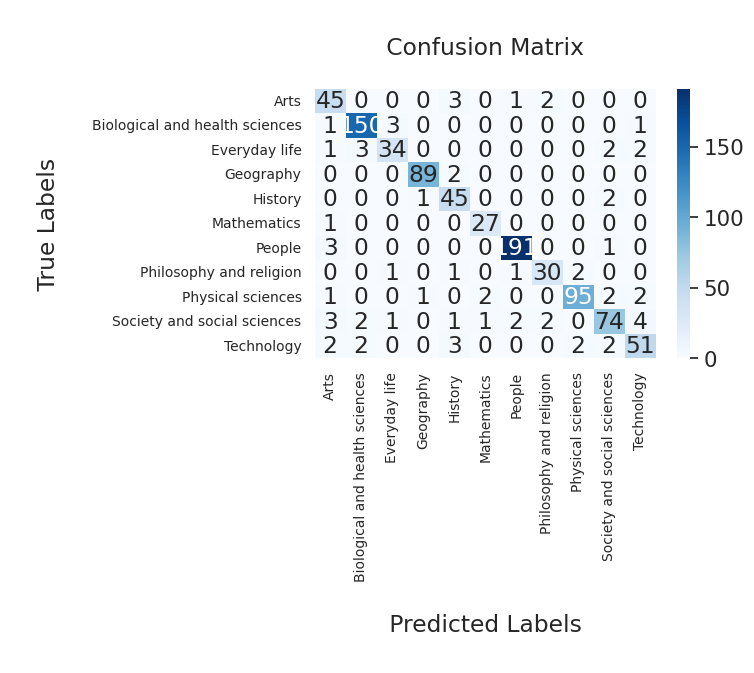

In [88]:
plt.figure(figsize=(5.5, 3.5))
sns.set(font_scale=1.4)

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=wikivitals.names_labels,
            yticklabels=wikivitals.names_labels)


plt.xlabel('\n Predicted Labels \n')
plt.ylabel('\n True Labels \n')
plt.title('\n Confusion Matrix \n')

plt.xticks(rotation=90, fontsize=10)
plt.yticks(rotation=0, fontsize=10)


plt.savefig('plot_folder/conf_matrix_lmm.png', bbox_inches='tight')
plt.show()

## Graph Model

In [68]:
! pip -q install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 44.7 MB/s eta 0:00:00


In [69]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch_geometric.nn import GCNConv, SAGEConv, GATConv

from torch_geometric.data import Data
import torch_geometric.transforms as T

import seaborn as sns
from sklearn.metrics import confusion_matrix

In [70]:
adj_matrix = wikivitals.adjacency.toarray().astype(int)

G = nx.from_numpy_array(wikivitals.adjacency.toarray())

print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

Number of nodes: 10011
Number of edges: 655192


In [71]:
node_features = []
node_labels = []

for node in tqdm(G.nodes()):

    word_indices = wikivitals.biadjacency[node].toarray()

    node_features.append(torch.tensor(word_indices, dtype=torch.float32).squeeze())
    node_labels.append(wikivitals.labels[node])

node_features_tensor = torch.stack(node_features)
node_labels_tensor = torch.tensor(node_labels, dtype=torch.long)

edge_index = torch.tensor(np.array(G.edges()).T, dtype=torch.long)
graph_data = Data(x=node_features_tensor, edge_index=edge_index, y=node_labels_tensor)

print(graph_data)

  0%|          | 0/10011 [00:00<?, ?it/s]

Data(x=[10011, 37845], edge_index=[2, 655192], y=[10011])


In [72]:
class GCN(nn.Module):
	def __init__(self, num_node_features, num_classes):
		super().__init__()

		self.conv1 = GCNConv(num_node_features, 256)
		self.conv2 = GCNConv(256, num_classes)

	def forward(self, data):
		x, edge_index = data.x, data.edge_index

		x = self.conv1(x, edge_index)
		x = F.relu(x)
		x = self.conv2(x, edge_index)

		return x

In [73]:
# ---------------------------------------------------------------------------------------#
def eval_node_classifier(model, graph, mask, is_test = False):

    model.eval()
    pred = model(graph).argmax(dim=1)
    correct	= (pred[mask] == graph.y[mask]).sum()
    acc = correct/mask.sum()

    true_p = ((pred[mask] == graph.y[mask]) & (pred[mask] == 1)).sum().item()
    false_p = ((pred[mask] != graph.y[mask]) & (pred[mask] == 1)).sum().item()
    false_n = ((pred[mask] != graph.y[mask]) & (pred[mask] == 0)).sum().item()

    precision = true_p / (true_p + false_p) if (true_p + false_p) > 0 else 0

    if is_test:
        recall = true_p / (true_p + false_n) if (true_p + false_n) > 0 else 0
        f1_score = (2*precision*recall)/(precision+recall)

        true_labels = graph.y[mask].cpu().numpy()
        conf_matrix = confusion_matrix(true_labels, pred[mask].cpu().numpy())

        return (acc.item(), precision, recall, f1_score, conf_matrix)

    return acc.item(), precision

# ---------------------------------------------------------------------------------------#
# ---------------------------------------------------------------------------------------#

def train_node_classifier(model, graph, optimizer, criterion, n_epochs = 200):

    train_lss_curve = []
    val_lss_curve = []

    evaluation = {"val_accuracy":[], "val_precision":[]}

    print("\n >> Training...\n")

    print(model, "\n")

    for epoch in range(1, n_epochs+1):
        model.train()
        optimizer.zero_grad()

        out = model(graph)
        loss = criterion(out[graph.train_mask], graph.y[graph.train_mask])
        train_lss_curve.append(loss.item())

        loss.backward(retain_graph=True)
        optimizer.step()

        with torch.no_grad():

          val_loss = criterion(out[graph.val_mask], graph.y[graph.val_mask])
          val_lss_curve.append(val_loss.item())

          acc, precision = eval_node_classifier(model, graph, graph.val_mask)

        evaluation["val_accuracy"].append(acc)
        evaluation["val_precision"].append(precision)

        if epoch%5 == 0:
            print (f' Epoch [{epoch:>2}/{n_epochs}] | Loss: {loss.item():.4f} | Val_loss {val_loss.item():.4f} | Val_acc {acc:.3f} - ')

    print()
    return model, train_lss_curve, val_lss_curve, evaluation
# ---------------------------------------------------------------------------------------#
# ---------------------------------------------------------------------------------------#


In [74]:
# hyperparameters

lr = 0.01
wd = 5e-4
n_epochs = 50

split = T.RandomNodeSplit(num_val=0.2, num_test=0.1)
graph = split(graph_data)
graph

Data(x=[10011, 37845], edge_index=[2, 655192], y=[10011], train_mask=[10011], val_mask=[10011], test_mask=[10011])

In [75]:
model = GCN(num_node_features= 37845, num_classes=11)

optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
criterion = torch.nn.CrossEntropyLoss()

model, train_lss_curve, val_lss_curve, evaluation = train_node_classifier(model, graph,
                                                                          optimizer, criterion,
                                                                          n_epochs)

CONV_results = eval_node_classifier(model, graph, graph.test_mask, is_test=True)

print(f'\n Test accuracy: {CONV_results[0]:.3f}% \n')


 >> Training...

GCN(
  (conv1): GCNConv(37845, 256)
  (conv2): GCNConv(256, 11)
) 

 Epoch [ 5/50] | Loss: 8.9797 | Val_loss 9.4699 | Val_acc 0.307 - 
 Epoch [10/50] | Loss: 4.7897 | Val_loss 4.8391 | Val_acc 0.468 - 
 Epoch [15/50] | Loss: 2.1492 | Val_loss 2.2786 | Val_acc 0.448 - 
 Epoch [20/50] | Loss: 1.5299 | Val_loss 1.5775 | Val_acc 0.577 - 
 Epoch [25/50] | Loss: 1.2435 | Val_loss 1.2530 | Val_acc 0.575 - 
 Epoch [30/50] | Loss: 1.0641 | Val_loss 1.1314 | Val_acc 0.667 - 
 Epoch [35/50] | Loss: 0.9350 | Val_loss 0.9915 | Val_acc 0.685 - 
 Epoch [40/50] | Loss: 0.8603 | Val_loss 0.9263 | Val_acc 0.705 - 
 Epoch [45/50] | Loss: 0.8057 | Val_loss 0.8745 | Val_acc 0.719 - 
 Epoch [50/50] | Loss: 0.7646 | Val_loss 0.8355 | Val_acc 0.728 - 


 Test accuracy: 0.710% 



In [76]:
gcn_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f' GCN total parameters: {gcn_total_params}')

 GCN total parameters: 9691403


In [77]:
module_path = '/content/Social_Networks/Homework'

if module_path not in sys.path: sys.path.append(module_path)

from Graph_NN import do_plot

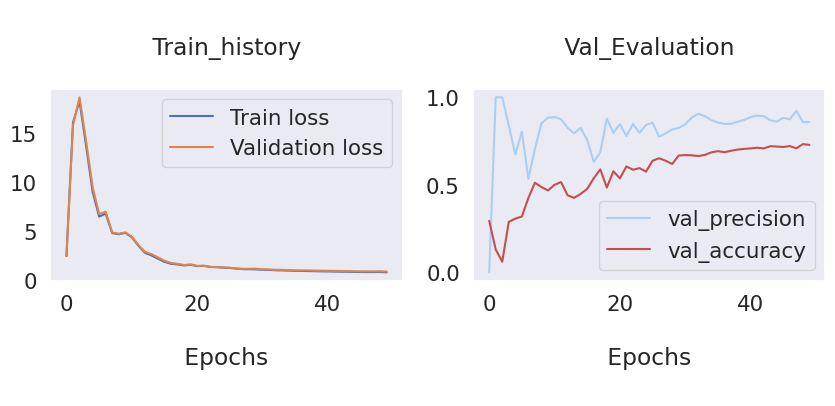

In [78]:
do_plot(n_epochs, train_lss_curve, val_lss_curve, evaluation)

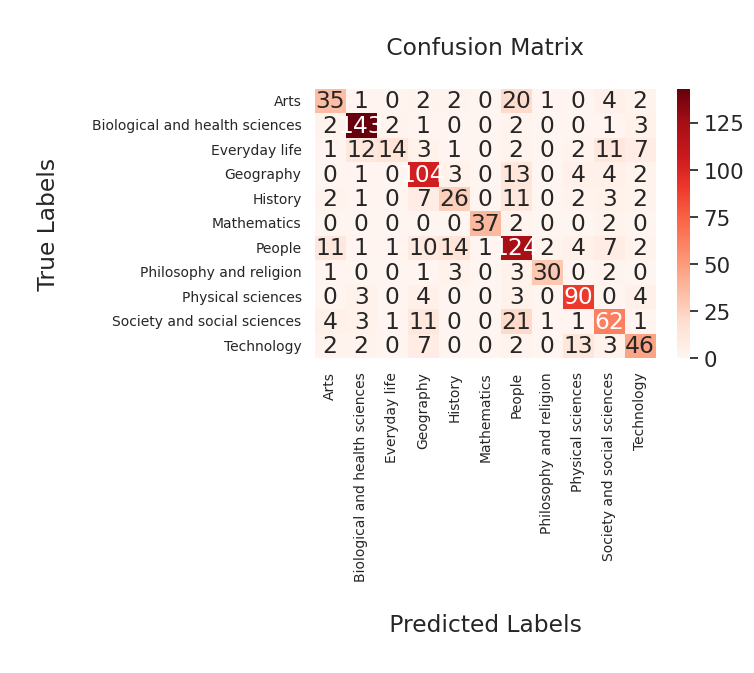

In [81]:
plt.figure(figsize=(5.5, 3.5))
sns.set(font_scale=1.4)

sns.heatmap(CONV_results[-1], annot=True, fmt='d', cmap='Reds',
            xticklabels=wikivitals.names_labels,
            yticklabels=wikivitals.names_labels)


plt.xlabel('\n Predicted Labels \n')
plt.ylabel('\n True Labels \n')
plt.title('\n Confusion Matrix \n')

plt.xticks(rotation=90, fontsize=10)
plt.yticks(rotation=0, fontsize=10)

plt.savefig('plot_folder/conf_matrix_gnn.png', bbox_inches='tight')
plt.show()

--------------------------------------------
----------------------------------------------

In [89]:
import imageio

from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

In [90]:
hidden = 512
embd_size = 128

self_conv1 = GCNConv(37845, hidden)
self_conv2 = GCNConv(hidden, embd_size)

def forward(graph_data):
    x = F.relu(self_conv1(graph_data.x, graph_data.edge_index))
    embeddings = self_conv2(x, graph_data.edge_index)
    return embeddings

embeddings = forward(graph_data)
print(f'embeddings.shape: {embeddings.shape}')

embeddings.shape: torch.Size([10011, 128])


In [91]:
x_np = embeddings.detach().numpy()
y_np = graph_data.y.detach().numpy()

pca = PCA(n_components=3)
x_pca = pca.fit_transform(x_np)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(x_pca[:, 0], x_pca[:, 1], x_pca[:, 2], c=y_np, cmap='tab10', s=10)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title(f'3D PCA of Embeddings = {embd_size}')

os.makedirs('frames', exist_ok=True)
frames = []

for angle in tqdm(range(0, 360, 3)):  # Rotate by 3 degrees per frame
    ax.view_init(30, angle)
    filename = f'frames/frame_{angle}.png'
    plt.savefig(filename)
    frames.append(imageio.v2.imread(filename))

plt.close()
imageio.mimsave('plot_folder/pca_rotation.gif', frames, fps=15)

  0%|          | 0/120 [00:00<?, ?it/s]

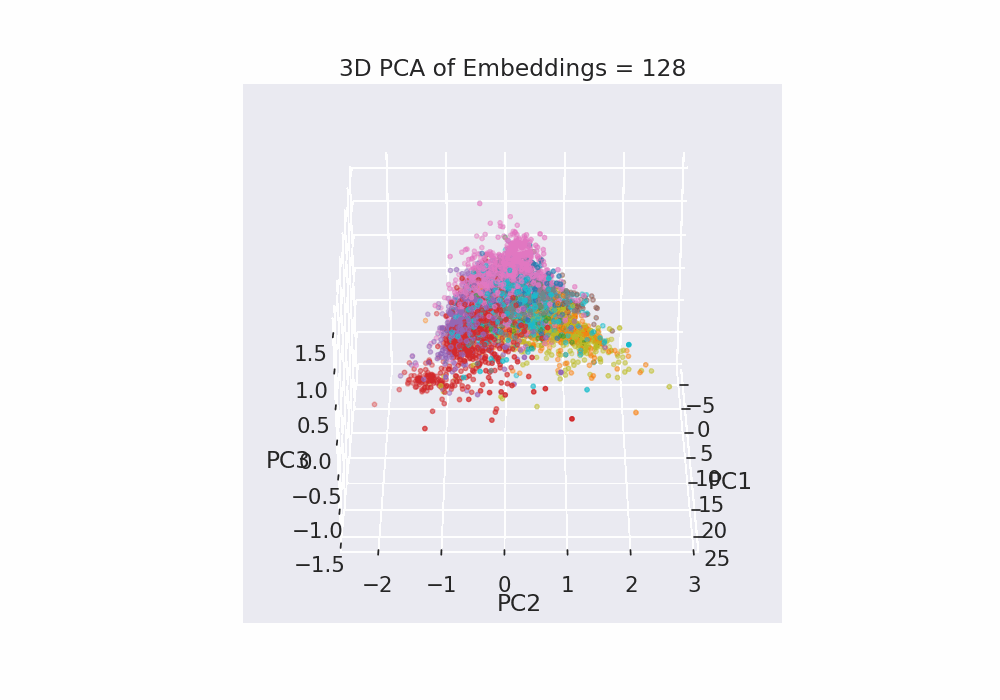

In [92]:
Image(open('pca_rotation.gif','rb').read())

## Shortest path lenght prediction:

In [ ]:
np.random.seed(999)

nodes = list(G.nodes)
landmarks = np.random.randint(1, len(nodes), 80)

distance_map = {}
distances = np.zeros((len(nodes), ))

for landmark in tqdm(landmarks):
    distances[:] = np.inf
    node_dists = nx.shortest_path_length(G, landmark)
    for key, value in node_dists.items():
        distances[key] = value
    distance_map[landmark] = distances.copy()

save_path = 'distance_map_wiki.pickle'
pickle.dump(distance_map, open(save_path, 'wb'))

In [ ]:
""" for each distance get the corresponding node embeddings and combine by averaging them.
this cell has a bug which causes emd_dist_pair to store some duplicate items. These duplicates are dropped later """

emd_dist_pair = []
for landmark in tqdm(list(distance_map.keys())):
    node_distances = distance_map[landmark]
    emd_dist_pair.extend([((embeddings[node]+embeddings[landmark])/2, distance) for node, distance in enumerate(node_distances, 0) if node != landmark and distance != np.inf])

print('length of embedding-distance pairs', len(emd_dist_pair))


In [ ]:
x = np.zeros((len(emd_dist_pair), len(emd_dist_pair[0][0] )))
y = np.zeros((len(emd_dist_pair), ))

In [ ]:
for i,tup in enumerate(tqdm(emd_dist_pair)):
  x[i] = tup[0].detach().numpy().astype('float32')
  y[i] = tup[1].astype('int')

print(f'shape x: {x.shape}')
print(f'shape y: {y.shape}')

In [ ]:
unique_labels, counts = np.unique(y, return_counts=True)
percentages = (counts / len(y)) * 100

plt.figure(figsize=(8, 4))
plt.bar(unique_labels, percentages, color='skyblue', edgecolor='black')

plt.xlabel('Labels', fontsize=12)

for i, percentage in enumerate(percentages):
    plt.text(unique_labels[i], percentage + 1, f'{percentage:.1f}%', ha='center', fontsize=12)

plt.xticks([int(i) for i in set(y)])
plt.ylim(0,100)
plt.tight_layout()
plt.grid()
plt.show()


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

from torch.utils import data as torch_data

In [ ]:
seed_random = 9999
np.random.seed(seed_random)
torch.backends.cudnn.deterministic = True
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed_random)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, train_size=0.75, random_state=seed_random, shuffle=True, stratify=y)
x_train, x_cv, y_train, y_cv = train_test_split(x_train, y_train, test_size=0.2, train_size=0.8, random_state=seed_random, shuffle=True, stratify=y_train)

print('shapes of train, validation, test data', x_train.shape, y_train.shape, x_cv.shape, y_cv.shape, x_test.shape, y_test.shape)

In [ ]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_cv = scaler.transform(x_cv)
x_test = scaler.transform(x_test)

pickle.dump((x_train, y_train), open('train_xy_no_sampling_stdScale.pk', 'wb'))
pickle.dump((x_cv, y_cv), open('val_xy_no_sampling_stdScale.pk', 'wb'))
pickle.dump((x_test, y_test), open('test_xy_no_sampling_stdScale.pk', 'wb'))

In [ ]:
# from imblearn.over_sampling import RandomOverSampler
# from imblearn.under_sampling import ClusterCentroids, TomekLinks, RandomUnderSampler
# from imblearn.over_sampling import KMeansSMOTE, SMOTE
#
# seed_random = 9999
#
# x = int(counts[2]*0.5)
# y = int(0.7 * x)
#
# undersample_dict = {2:y, 3:x}
# under_sampler = RandomUnderSampler(sampling_strategy=undersample_dict, random_state=seed_random)
# x_train, y_train = under_sampler.fit_resample(x_train, y_train)
#
#
# minority_samples = int(0.8*x)
# oversample_dict = {1:minority_samples, 4:minority_samples}
# over_sampler = RandomOverSampler(sampling_strategy=oversample_dict, random_state=seed_random)
# x_train, y_train = over_sampler.fit_resample(x_train, y_train)
#
# x_train.shape, y_train.shape

In [ ]:
plt.figure(figsize=(6, 3))

unique_labels, counts = np.unique(y_train, return_counts=True)
percentages = (counts / len(y_train)) * 100

plt.bar(unique_labels, percentages, color='lightgreen', edgecolor='black')

plt.title("len(paths) in x_train")
plt.xlabel('Labels', fontsize=12)

for i, percentage in enumerate(percentages):
    plt.text(unique_labels[i], percentage + 10, f'{percentage:.1f}%', ha='center', fontsize=12)

plt.xticks([int(i) for i in set(y_train)])
plt.ylim(0,100)
plt.tight_layout()
plt.grid()
plt.show()

In [ ]:
params = {'input_size':128, 'hidden_units_1':64,
                            'hidden_units_2': 4, #'hidden_units_3':50,
                             'output_size': 1, 'lr': 0.01, 'min_lr': 1e-05, 'max_lr': 0.003,
             'epochs': 15, 'lr_sched': 'clr', 'lr_sched_mode': 'triangular', 'gamma': 0.95, 'batch_size': 1000,}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
torch.manual_seed(9999)
def get_model(params):
    """
    creates a PyTorch model. Change the 'params' dict above to
    modify the neural net configuration.
    """
    model = torch.nn.Sequential(
        torch.nn.Linear(params['input_size'], params['hidden_units_1']),
        torch.nn.BatchNorm1d(params['hidden_units_1']),
        # torch.nn.Dropout(p=params['do_1']),
        torch.nn.ReLU(),
        torch.nn.Linear(params['hidden_units_1'], params['hidden_units_2']),
        torch.nn.BatchNorm1d(params['hidden_units_2']),
        # torch.nn.Dropout(p=params['do_2']),
        torch.nn.ReLU(),

        # torch.nn.Linear(params['hidden_units_2'], params['hidden_units_3']),
        # torch.nn.BatchNorm1d(params['hidden_units_3']),
        # # torch.nn.Dropout(p=params['do_3']),
        # torch.nn.ReLU(),
        torch.nn.Linear(params['hidden_units_2'], params['output_size']),
        torch.nn.ReLU(),
        # torch.nn.Softplus(),
    )
    model.to(device)
    return model

def poisson_loss(y_pred, y_true):
    """
    Custom loss function for Poisson model.
    Equivalent Keras implementation for reference:
    K.mean(y_pred - y_true * math_ops.log(y_pred + K.epsilon()), axis=-1)
    For output of shape (2,3) it return (2,) vector. Need to calculate
    mean of that too.
    """
    y_pred = torch.squeeze(y_pred)
    loss = torch.mean(y_pred - y_true * torch.log(y_pred+1e-7))
    return loss

def evaluate(model, dl):
    """
    This function is used to evaluate the model with validation.
    args: model and data loader
    returns: loss
    """
    model.eval()
    final_loss = 0.0
    count = 0
    with torch.no_grad():
        for data_cv in dl:
            inputs, dist_true = data_cv[0], data_cv[1]
            count += len(inputs)
            outputs = model(inputs)
            loss = loss_fn(outputs, dist_true)
            final_loss += loss.item()
    return final_loss/len(dl)

In [ ]:
model = get_model(params)

model

In [ ]:
lr_reduce_patience = 20
lr_reduce_factor = 0.1

loss_fn = poisson_loss
optimizer = torch.optim.RMSprop(model.parameters(), lr=params['lr'], alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False)

if params['lr_sched'] == 'reduce_lr_plateau':
    lr_sched = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                                                                     factor=lr_reduce_factor,
                                                                     patience=lr_reduce_patience,
                                                                     verbose=True, threshold=0.00001, threshold_mode='rel',
                                                                     cooldown=0, min_lr=1e-9, eps=1e-08)
elif params['lr_sched'] == 'clr':
    lr_sched = torch.optim.lr_scheduler.CyclicLR(optimizer, params['min_lr'],
                                                            params['max_lr'],
                                                            step_size_down=None,
                                                            mode=params['lr_sched_mode'],
                                                            last_epoch=-1, gamma=params['gamma'])



In [ ]:
trainset = torch_data.TensorDataset(torch.as_tensor(x_train, dtype=torch.float, device=device),
torch.as_tensor(y_train, dtype=torch.float, device=device))
train_dl = torch_data.DataLoader(trainset, batch_size=params['batch_size'], drop_last=True)

val_dl = torch_data.DataLoader(torch_data.TensorDataset(torch.as_tensor(x_cv, dtype=torch.float, device=device),
torch.as_tensor(y_cv, dtype=torch.float, device=device)), batch_size=params['batch_size'], drop_last=True)

test_dl = torch_data.DataLoader(torch_data.TensorDataset(torch.as_tensor(x_test, dtype=torch.float, device=device),
torch.as_tensor(y_test, dtype=torch.float, device=device)), batch_size=params['batch_size'], drop_last=True)

In [ ]:
start_epoch = 0
iter_count = 0
train_losses = []
val_losses = []

for epoch in range(start_epoch, start_epoch+params['epochs']):  # loop over the dataset multiple times
    running_loss = 0.0

    for i, data in enumerate(train_dl, 0):
        iter_count += 1
        # get the inputs; data is a list of [inputs, dist_true]
        model.train()
        inputs, dist_true = data[0], data[1]
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = loss_fn(outputs, dist_true)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        last_loss = loss.item()

        if not isinstance(lr_sched, torch.optim.lr_scheduler.ReduceLROnPlateau):
            lr_sched.step()

    val_loss = evaluate(model, val_dl)

    train_loss = running_loss/len(train_dl)
    train_losses.append(train_loss)
    val_losses.append(val_loss)


    print("epoch:{} -> train_loss={},val_loss={} ".format(epoch,
                                                          round(train_loss, 5),
                                                          round(val_loss, 5)))

print('Finished Training')

In [ ]:
def test(model, dl):
    model.eval()
    final_loss = 0.0
    count = 0
    y_hat = []
    with torch.no_grad():
        for data_cv in dl:
            inputs, dist_true = data_cv[0], data_cv[1]
            count += len(inputs)
            outputs = model(inputs)
            y_hat.extend(outputs.tolist())
            loss = loss_fn(outputs, dist_true)
            final_loss += loss.item()
    return final_loss/len(dl), y_hat


test_loss, y_hat = test(model, test_dl)

print(f'    test_loss: {round(test_loss, 4)}')
print(f'test_accuracy: {str(accuracy_score(y_test[:len(y_hat)], np.round(y_hat)))}')

In [ ]:
y_hat_ = np.array(y_hat).squeeze()
y_test_ = y_test[:len(y_hat)]

dist_accuracies = []
dist_counts = []
for i in range(1, 8):
    mask = y_test_==i
    dist_values = y_test_[mask]
    dist_preds = np.round(y_hat_[mask])
    dist_accuracies.append(np.sum(dist_values == dist_preds)*100/len(dist_values))
    dist_counts.append(len(dist_values))

fig = plt.figure(figsize=(6,3))

plt.bar(range(1,8), dist_accuracies)
for index, value in enumerate(dist_accuracies):
  if not np.isnan(value):
    plt.text(index+0.8, value, str(np.round(value, 2))+'%')

plt.title('distance accuracy')
plt.xlabel('distance values')
plt.ylabel('accuracy')

plt.xticks(range(1,5))
plt.ylim(0,100)
plt.grid()
plt.show()


In [ ]:
start_node_idx = 2988   # Exponential distribution
end_node_idx = 2071      # Corvus

shortest_path = dijkstra_shortest_path(G, start_node_idx, end_node_idx)

print('\n Start:', end = " ")
for i, idx_number in enumerate(shortest_path):

  print(f'[{wikivitals.names[idx_number]}] → ', end = "")

print(f'destination || len = {len(shortest_path)}')

In [ ]:
mix_embedding = (embeddings[start_node_idx]+embeddings[end_node_idx])/2

outputs = model(mix_embedding.unsqueeze(0).to(device))

print(f' predicted path lenght: {round(outputs.item())}')

In [ ]:
counts[2]*0.7

In [ ]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import ClusterCentroids, TomekLinks, RandomUnderSampler
from imblearn.over_sampling import KMeansSMOTE, SMOTE

seed_random = 9999

x = int(counts[2]*0.5)
y = int(0.7 * x)

undersample_dict = {2:y, 3:x}
under_sampler = RandomUnderSampler(sampling_strategy=undersample_dict, random_state=seed_random)
x_train, y_train = under_sampler.fit_resample(x_train, y_train)


minority_samples = int(0.8*x)
oversample_dict = {1:minority_samples, 4:minority_samples}
over_sampler = RandomOverSampler(sampling_strategy=oversample_dict, random_state=seed_random)
x_train, y_train = over_sampler.fit_resample(x_train, y_train)

x_train.shape, y_train.shape

In [ ]:
plt.hist(y_train)